# From Bayes to BERT: Classification Approaches in NLP
***
[Alejandro Ciuba](https://alejandrociuba.github.io), alejandrociuba@pitt.edu
***
## Summary

This presentation looks at the various ways we can build and evaluate NLP pipelines for text classification tasks like author identification or sentiment analysis. The presentation plans to cover the following approaches:

0. [Data Exploration](#data-exploration)
1. [Simple Knowledge Base](#simple-knowledge-base)
2. [Naive Bayes Classifier](#naive-bayes-classifier)
3. [K-Nearest Neighbors](#k-nearest-neighbors)
4. [Support Vector Machine](#support-vector-machines)
5. [Logistic Regression](#logistic-regression)
6. [Feed-Forward Neural Network](#feed-forward-neural-network)
7. [Recurrent Neural Network](#recurrent-neural-network)
8. [Simple Transformer](#simple-transformer)
9. [HuggingFace Transformers](#huggingface-transformers)
***
## Necessary Imports & Setup
### General

In [9]:
# These imports are required to run the notebook
from pathlib import Path

import math
import nltk
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Metrics

In [10]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             confusion_matrix,
                             roc_curve,)

### Preprocessing & Vectorization

In [11]:
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer,
                                             ENGLISH_STOP_WORDS,)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

### Machine-Learning Models

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

### Deep-Learning Models

Only for the deep learning models ([Feed-Forward Neural Networks](#feed-forward-neural-network) and beyond). All other sections *should* work without these loaded. Please let me know if they do not.

In [13]:
from collections import OrderedDict
from torch.utils.data import (Dataset, 
                              DataLoader,
                              TensorDataset)

import torch

import torch.nn as nn
import torch.optim as optim

### HuggingFace Transformers

You don't need to run this block if you are interested in everything else.

In [14]:
from transformers import pipeline

### Ignore The Knowledge Base Implementation

The knowledge base was modified from a previous homework I did for *CS2710: Foundations in AI*, and as such I will not be uploading it to the repository. Please run this to ignore the cells that require this import

In [15]:
ALEJANDRO = True  # I'm me, lol

if ALEJANDRO:    
    from kb.Propositional_KB_agent import *

### Load The Datasets

The dataset was gotten from [Project Gutenberg](https://www.gutenberg.org). I already cleaned up the texts a bit (remove chapter headings, the pre-/post-ambles and some of the extra whitespace). I also converted the works into a `.csv` for the presentation, but there's still some more cleaning we can easily do here. While we're focusing on Jane Austen vs. Herman Melville classification, we also have some Tolstoy in the mix.

In [16]:
PATH = Path("./datasets/")  # Overkill in this instance but useful in general
df = pd.read_pickle(PATH / "dataset.pkl")

# Remove any forgotten whitespace and puncuations (already sentences)
CLEANER = re.compile(r"[“”\"\\\n\t\r,\.\?\!\[\]\{\}\(\)]", re.I)

def clean(line: str) -> str: 
    return CLEANER.sub("", line.lower())

# Create a tokenized word column
df["line"] = df["line"].map(clean)
df["tokens"] = df["line"].map(nltk.word_tokenize)

df.sample(10)


,author,book,line,tokens
141165,tolstoy,war_and_peace,so we are to have visitors mon prince remarked...,"[so, we, are, to, have, visitors, mon, prince,..."
238170,tolstoy,anna_karenina,but on her arrival in petersburg she was sudde...,"[but, on, her, arrival, in, petersburg, she, w..."
176367,tolstoy,war_and_peace,and with such fine fellows to retreat and retreat,"[and, with, such, fine, fellows, to, retreat, ..."
61929,austen,emma,while he lived it must be only an engagement; ...,"[while, he, lived, it, must, be, only, an, eng..."
56292,austen,emma,_we_ have carriages to fetch and convey her ho...,"[_we_, have, carriages, to, fetch, and, convey..."
194343,tolstoy,war_and_peace,from whom came a sleepy voice,"[from, whom, came, a, sleepy, voice]"
48018,austen,emma,she was obliged to go the next morning for an ...,"[she, was, obliged, to, go, the, next, morning..."
92817,melville,moby_dick,there’s a pretty fellow now he banteringly lau...,"[there, ’, s, a, pretty, fellow, now, he, bant..."
177399,tolstoy,war_and_peace,to anyone who looks at the field of borodinó w...,"[to, anyone, who, looks, at, the, field, of, b..."
208722,tolstoy,anna_karenina,she was afraid that her daughter who had at on...,"[she, was, afraid, that, her, daughter, who, h..."


### Useful Helper Functions

In [17]:
def get_metrics(targets, predictions):
    """
    Gets all the metrics we will be using to evaluate the model's performance.
    """

    acc = accuracy_score(y_true=targets, y_pred=predictions)
    prec = precision_score(y_true=targets, y_pred=predictions, average="macro")
    rec = recall_score(y_true=targets, y_pred=predictions, average="macro")
    f1 = f1_score(y_true=targets, y_pred=predictions, average="macro")
    conf = confusion_matrix(y_true=targets, y_pred=predictions)

    return acc, prec, rec, f1, conf

In [18]:
def plot_confusion_matrix(cm, labels):
    """
    Plots the confusion matrix (thanks to Dr. Na-Rae Han).
    """
    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="Reds", 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()

In [19]:
def plot_calibration_curve(y_test, probs, bins = 10, label = ""):
    """
    Plots the calibration curve.
    """
    # Modified from geeksforgeeks https://www.geeksforgeeks.org/calibration-curves/
    # Creating Calibration Curve
    x, y = calibration_curve(y_test, probs, n_bins = 10)
    
    # Plot calibration curve
    
    # Plot perfectly calibrated
    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
    
    # Plot model's calibration curve
    plt.plot(y, x, marker = '.', label = label)
    
    leg = plt.legend(loc = 'upper left')
    plt.xlabel('Average Predicted Probability in each bin')
    plt.ylabel('Ratio of positives')
    plt.show()

In [20]:
def plot_roc_curve(y_test, probs, label=""):
    """
    Plots the receiver-operator curve
    """
    # https://medium.com/@shuv.sdr/na%C3%AFve-bayes-classification-in-python-f869c2e0dbf1
    # Plot AUC/ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(fpr, tpr, label=label, color = 'firebrick')
    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    plt.box(False)
    ax.legend()

In [77]:
def train_dl(model: nn.Module, epochs: int, dataloader: DataLoader,
             criterion, optimizer) -> list[float]:
    """
    The actual training loop for most of our deep learning models.
    """
    
    steps = len(dataloader)  # The batch size
    loss = None
    loss_tracker = []  # Save the loss at every check

    model.train(True)  # Track gradients for back propagation

    for epoch in range(epochs):

        for i, (inputs, label) in enumerate(dataloader):

            # Forward
            y_pred = model(inputs)
            loss = criterion(y_pred, label)

            # Backpropagation
            loss.backward()

            # Update
            optimizer.step()
            optimizer.zero_grad()

            # Show statistics and track loss change over time
            if i % 100 == 0:
                print(f'epoch: {epoch + 1}/{epochs}, step: {i}/{steps}, loss:{loss.item(): .5f}')
                loss_tracker.append(loss.item())

    print(f"Final loss: {loss.item()}")

    return loss_tracker

In [80]:
def plot_loss(loss, epochs, model_name):
    """
    Plots the loss that train_dl returns.
    """

    sns.lineplot(x = np.linspace(start=0, stop=epochs, num=9 * epochs), y=loss)
    plt.title(model_name)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show()

***
## Data Exploration

Let's briefly look at our data before we get started. First, what are the authors and which of their works are we basing our decision on?

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83441 entries, 0 to 256356
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   author  83441 non-null  object
 1   book    83441 non-null  object
 2   line    83441 non-null  object
 3   tokens  83441 non-null  object
dtypes: object(4)
memory usage: 3.2+ MB


In [24]:
print(f"Authors: {', '.join([name.capitalize() for name in df.author.unique()])}")
print(f"Works: {', '.join(df.book.unique())}")
print(f"Total Tokens: {sum([len(toks) for toks in df.tokens.to_list()]):,d}")

Authors: Austen, Melville, Tolstoy
Works: sense_and_sensibility, mansfield_park, lady_susan, pride_and_prejudice, emma, redburn, moby_dick, the_condifence_man, piazza_tales, bartleby, war_and_peace, anna_karenina
Total Tokens: 2,070,836


Text(0.5, 1.0, 'Sentences per Author n=83441')

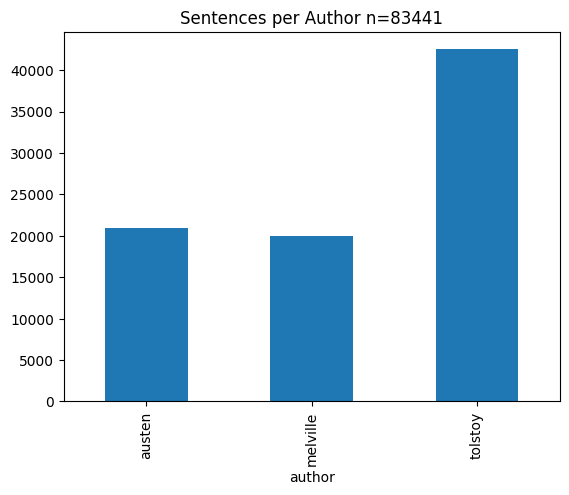

In [25]:
df.groupby(["author"]).line.count().plot(kind="bar")
plt.title(f"Sentences per Author n={len(df)}")

Text(0.5, 1.0, 'Sentences per Author n=83441')

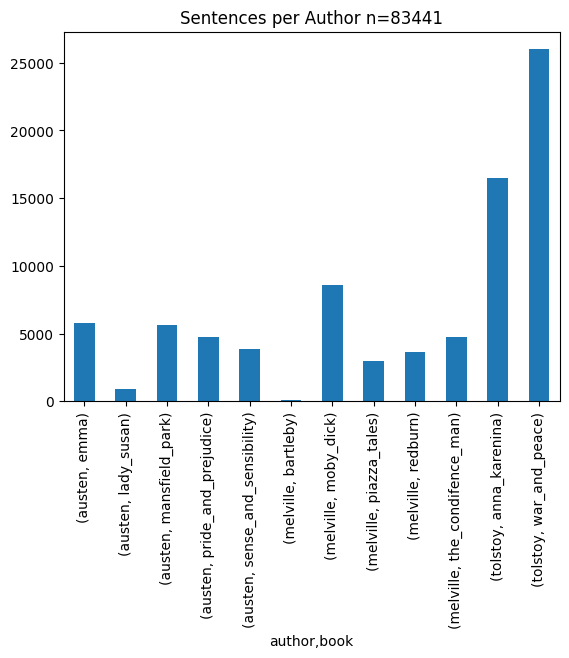

In [26]:
df.groupby(["author", "book"]).line.count().plot(kind="bar")
plt.title(f"Sentences per Author n={len(df)}")

Let's look at tokens specifically. Here, we look at the **Type-Token Ratio**, this helps us understand how *diverse* our tokens are. A TTR closer to 1 means we have many unique tokens.

$$\mathrm{TTR} = \frac{ | \mathrm{set(tokens) | }}{| \mathrm{sequence(tokens)} |}$$

In [27]:
tokens = [toks for tok_list in df.tokens.to_list() for toks in tok_list]
print(tokens[:10])
print(f"TTR: {len(set(tokens)) / len(tokens):.5f}")

['\ufeffthe', 'family', 'of', 'dashwood', 'had', 'long', 'been', 'settled', 'in', 'sussex']
TTR: 0.02428


In [28]:
# Per book
sub_ttrs = []
for book in df.book.unique():
    sub_df = df[df.book == book]
    sub_toks = [toks for tok_list in sub_df.tokens.to_list() for toks in tok_list]
    sub_ttrs.append(len(set(sub_toks)) / len(sub_toks))
    print(f"{book.capitalize()} TTR: {len(set(sub_toks)) / len(sub_toks):.5f}")

# Total
sub_ttrs.append(len(set(tokens)) / len(tokens))

Sense_and_sensibility TTR: 0.05891
Mansfield_park TTR: 0.05183
Lady_susan TTR: 0.12679
Pride_and_prejudice TTR: 0.05441
Emma TTR: 0.06140
Redburn TTR: 0.10338
Moby_dick TTR: 0.09086
The_condifence_man TTR: 0.11339
Piazza_tales TTR: 0.13847
Bartleby TTR: 0.33550
War_and_peace TTR: 0.03455
Anna_karenina TTR: 0.03930


/tmp/ipykernel_26379/3376992347.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=books, y=sub_ttrs, palette=palette)


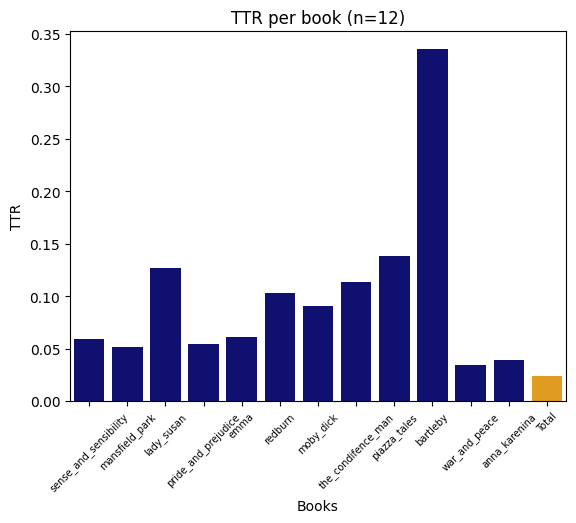

In [29]:
books = np.append(df.book.unique(), ["Total"], axis=0)
palette = ['orange' if x == "Total" else 'navy' for x in books]
sns.barplot(x=books, y=sub_ttrs, palette=palette)
plt.xticks(books, rotation=45, size=7)
plt.xlabel("Books")
plt.ylabel("TTR")
plt.title(f"TTR per book (n={len(df.book.unique())})")
plt.show()

Now for authors.

In [30]:
# Per author
sub_ttrs = []
for author in df.author.unique():
    sub_df = df[df.author == author]
    sub_toks = [toks for tok_list in sub_df.tokens.to_list() for toks in tok_list]
    sub_ttrs.append(len(set(sub_toks)) / len(sub_toks))
    print(f"{author.capitalize()} TTR: {len(set(sub_toks)) / len(sub_toks):.5f}")

# Total
sub_ttrs.append(len(set(tokens)) / len(tokens))

Austen TTR: 0.02866
Melville TTR: 0.06077
Tolstoy TTR: 0.02669


/tmp/ipykernel_26379/2569198944.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=authors, y=sub_ttrs, palette=palette)


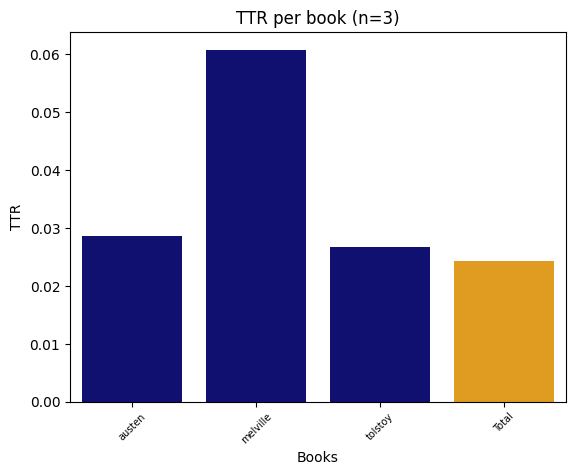

In [31]:
authors = np.append(df.author.unique(), ["Total"], axis=0)
palette = ['orange' if x == "Total" else 'navy' for x in authors]
sns.barplot(x=authors, y=sub_ttrs, palette=palette)
plt.xticks(authors, rotation=45, size=7)
plt.xlabel("Books")
plt.ylabel("TTR")
plt.title(f"TTR per book (n={len(df.author.unique())})")
plt.show()

We should definitely see what are the most common words in the dataset. This is probably going to be a lot of stop words (*the*, *a*, *but*, *and*, etc.), but who knows...

In [32]:
# Use the nltk.FreqDist class!
toks_freq = nltk.FreqDist(tokens)
print(toks_freq)

<FreqDist with 50283 samples and 2070836 outcomes>


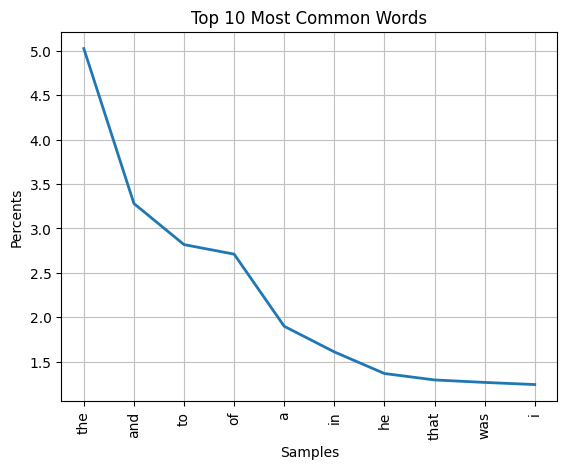

<Axes: title={'center': 'Top 10 Most Common Words'}, xlabel='Samples', ylabel='Percents'>

In [33]:
# Top ten
toks_freq.plot(10, title="Top 10 Most Common Words", percents=True)

What do you notice about the most common words? What about their percentages sticks out? Lastly, let's look at the most common **non-stopwords** and their TTR. Unicode quotations gotten from [here](https://www.cl.cam.ac.uk/~mgk25/ucs/quotes.html).

In [34]:
puncts = {',', '"', "'", "'", "‘", "’", '“', '”',
          ';', ':', '/', '\\',  '(', ')', '[', ']',
          '{', '}',}
full_stop = ENGLISH_STOP_WORDS.union(puncts)
non_stop = [tok for tok in tokens if tok not in full_stop]
print(f"TTR: {len(set(non_stop)) / len(non_stop):.5f}")

TTR: 0.05869


In [35]:
non_stop_freqs = nltk.FreqDist(non_stop)
print(non_stop_freqs)

<FreqDist with 49970 samples and 851402 outcomes>


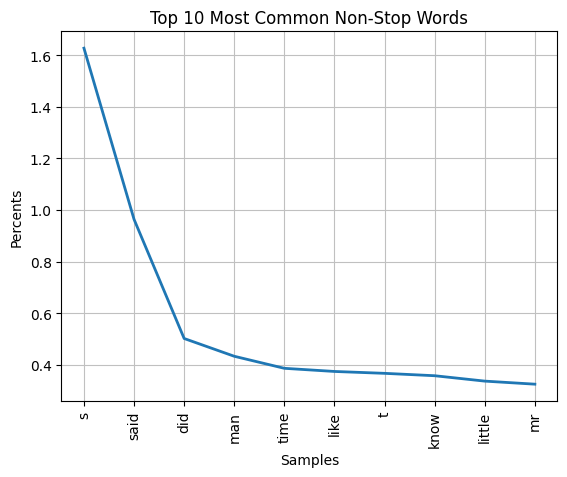

<Axes: title={'center': 'Top 10 Most Common Non-Stop Words'}, xlabel='Samples', ylabel='Percents'>

In [36]:
non_stop_freqs.plot(10, title="Top 10 Most Common Non-Stop Words", percents=True)

What do you notice here? Pay attention to the percentages! Now that we took a small look at our data, let's get into it!
***
## Simple Knowledge Base

While not necessarily used for classification, knowledge bases are a way to represent given rules (implications [`p -> q`]) and facts (literals [`p`]) about a *domain of discourse,* a group of objects. From these rules and facts, we can algorithmically deduce new rules (forward chaining) or prove new theorems (backward chaining).

In [37]:
# Get all the sentences for Emma and Moby Dick
if ALEJANDRO:
    kb_df = df[(df.book == "emma") | (df.book == "moby_dick")]
    kb_df.sample(10)

In [38]:
# Define the rules for Jane Austen and Herman Melville
if ALEJANDRO:
    austen = {'Emma', 'Harriet', 'Weston', 'Knightley', 
            'Elton','Woodhouse', 'Jane', 'Fairfax', 
            'Churchill', 'Frank', 'Hartfield', 'Bates', 
            'Highbury', 'Perry', 'Cole', 'Goddard', 
            'Campbell', 'Donwell', 'Dixon', 'Taylor',}

    melville = {'Ahab','Queequeg', 'Pequod', 'Bildad', 
                'Stubb', 'Starbuck', 'Peleg', 'Pip', 
                'Tashtego', 'Charley'}

    austen = [Rule(f"R{i}", [name.lower()], "emma") for i, name in enumerate(austen)]
    melville = [Rule(f"R{i}", [name.lower()], "moby_dick") for i, name in enumerate(melville)]

    kb_austen = KB(init_RB=austen)
    kb_melville = KB(init_RB=melville)

In [39]:
if ALEJANDRO:
    kb_austen.print_RB()

R0
If: ['jane']
Then: emma
 
R1
If: ['hartfield']
Then: emma
 
R2
If: ['taylor']
Then: emma
 
R3
If: ['bates']
Then: emma
 
R4
If: ['weston']
Then: emma
 
R5
If: ['knightley']
Then: emma
 
R6
If: ['perry']
Then: emma
 
R7
If: ['elton']
Then: emma
 
R8
If: ['highbury']
Then: emma
 
R9
If: ['donwell']
Then: emma
 
R10
If: ['emma']
Then: emma
 
R11
If: ['fairfax']
Then: emma
 
R12
If: ['goddard']
Then: emma
 
R13
If: ['woodhouse']
Then: emma
 
R14
If: ['cole']
Then: emma
 
R15
If: ['harriet']
Then: emma
 
R16
If: ['frank']
Then: emma
 
R17
If: ['campbell']
Then: emma
 
R18
If: ['dixon']
Then: emma
 
R19
If: ['churchill']
Then: emma
 


Since our knowledge base is simple, this becomes a simple check on the rules. No forward or backward chaining necessary.

In [40]:
if ALEJANDRO:
    def predict(tokens):

        # Reset the facts each time
        kb_austen.reset_FB()
        kb_melville.reset_FB()

        kb_austen.add_facts(tokens)
        kb_melville.add_facts(tokens)

        if forwardchain(kb_austen, "emma"):
            return "emma"
        elif forwardchain(kb_melville, "moby_dick"):
            return "moby_dick"
        else:
            return "no_answer"
            
    kb_df["prediction"] = kb_df["tokens"].map(predict)

    kb_df.sample(10)

/tmp/ipykernel_26379/2958747777.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kb_df["prediction"] = kb_df["tokens"].map(predict)


/home/computer_cat/miniconda3/envs/pyling/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.2693
Precision: 0.6662
Recall: 0.1994
F1 Score: 0.2925


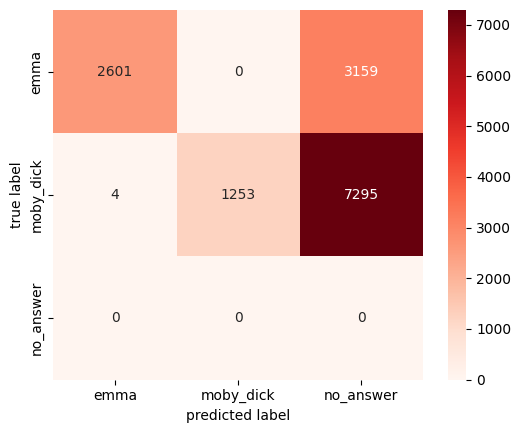

In [41]:
# Check the metrics
if ALEJANDRO:

    acc, prec, rec, f1, conf = get_metrics(targets=kb_df["book"], predictions=kb_df["prediction"])
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    plot_confusion_matrix(conf, labels=["emma", "moby_dick", "no_answer"])

***
## Naive Bayes Classifier
The Naive Bayes Classifier uses Bayes' rule to predict if a given string of text is one of two classes.

$$P(\mathrm{tag} \vert \mathrm{words}) = \frac{P(\mathrm{words} \vert \mathrm{tag}) \times P(\mathrm{tag})}{P(\mathrm{words})}$$

But what exactly are the $\mathrm{words}$ in this case? Sure, we could use the raw counts of each word, but that might not give us enough information. NBC assumes *feature independence* and that the features are unordered (*bag of words*) meaning it does not consider how the probability changes as more words are added. We want words that appear more to have more weight, and we want to capture something about the relationship between these words. This is *feature engineering.*

First, let's get our data in a simpler format. Let's start with turning our labels (authors and books) into numbers!

In [42]:
authors = LabelEncoder()
df["author_label"] = authors.fit_transform(df.author)

books = LabelEncoder()
df["book_label"] = authors.fit_transform(df.book)

df.sample(2)

,author,book,line,tokens,author_label,book_label
209229,tolstoy,anna_karenina,ah he began joyously,"[ah, he, began, joyously]",2,0
42627,austen,pride_and_prejudice,and there are several of the young men too tha...,"[and, there, are, several, of, the, young, men...",0,7


First, let's just predict between Jane Austen and Herman Melville. We need to filter our dataset for only these two authors and then create a training-testing split!

In [43]:
nb1_df = df[(df.author == "austen") | (df.author == "melville")]

X_train, X_test, y_train, y_test = train_test_split(nb1_df["line"].to_list(), nb1_df["author_label"].to_list(), train_size=0.7, random_state=42)

print(X_train[0])
print(y_train[0])

print(len(X_train), len(X_test))

i should like to conclude the chapter with the above appeal but cannot owing to my anxiety to repel a charge often made against whalemen and which in the estimation of some already biased minds might be considered as indirectly substantiated by what has been said of the frenchman’s two whales
1
28667 12287


To start off, let's use simple *count-based features*. This means a word's numerical representation is simply the number of times it appears in the dataset.

In [44]:
example = CountVectorizer(max_features=10, max_df=0.7, ngram_range=(1, 3), stop_words="english")
counts = example.fit_transform(X_train)

print(counts.shape)
print(example.vocabulary_)

(28667, 10)
{'like': 3, 'said': 8, 'know': 2, 'good': 1, 'did': 0, 'mr': 6, 'mrs': 7, 'time': 9, 'man': 5, 'little': 4}


We can combine models and feature preprocessing via *pipelines!*

In [45]:
nb_pipe = make_pipeline(CountVectorizer(max_features=2000, max_df=0.7, ngram_range=(1, 3), stop_words="english"),
                           MultinomialNB())

nb_pipe.fit(X=X_train, y=y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.7, max_features=2000,
                                 ngram_range=(1, 3), stop_words='english')),
                ('multinomialnb', MultinomialNB())])

Let's test it to see how it performs on the training data

In [46]:
predictions = nb_pipe.predict(X_test)

Accuracy: 0.8642
Precision: 0.8679
Recall: 0.8630
F1 Score: 0.8635


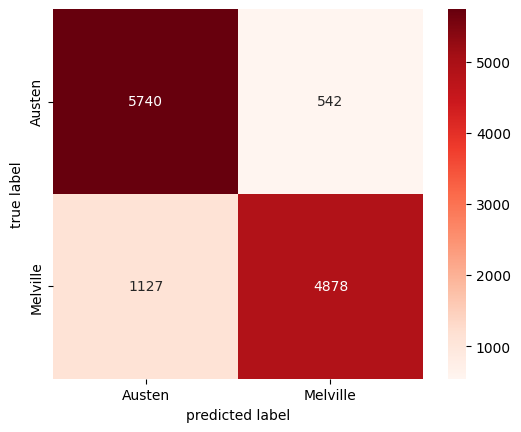

In [47]:
acc, prec, rec, f1, conf = get_metrics(targets=y_test, predictions=predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf, labels=["Austen", "Melville"])

Label metrics are good, but they don't tell us anything about the model's probability labelling. Remember, this is all ultimately based on probabilities! Sklearn hides this process from us, splitting the labels at the 0.5 threshold.

$$\mathrm{Label}(\mathrm{label}_{0}, \mathrm{label}_{1}, \mathrm{words}) = 0 \ \mathrm{if} \ (P(\mathrm{label}_{0} \vert \mathrm{words})) < 0.5 \ \mathrm{else} \ 1 $$

Let's look at the actual probabilities this time and examine the model's *calibration!*

In [48]:
prob_preds = nb_pipe.predict_proba(X_test)

print(prob_preds[0])

[0.00132594 0.99867406]


Let's look at the model's **calibration curve**! Essentially, the model's probabilities for a label should match the frequency we see that label in the dataset!

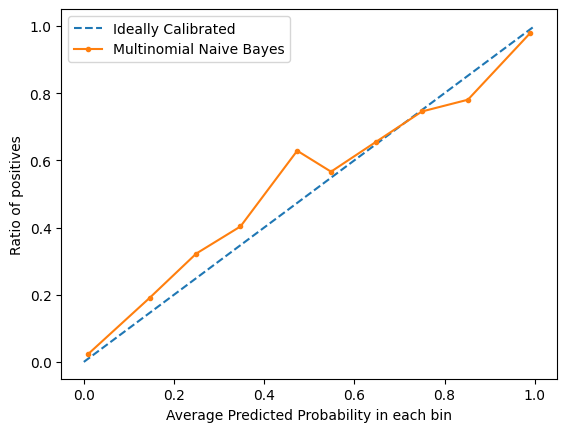

In [49]:
plot_calibration_curve(y_test, prob_preds[:, 1], label="Multinomial Naive Bayes")

Let's also look at the **Area Under the Receiver Operator Curve (AUROC)**, which tells us how our model performs at different classification thresholds!

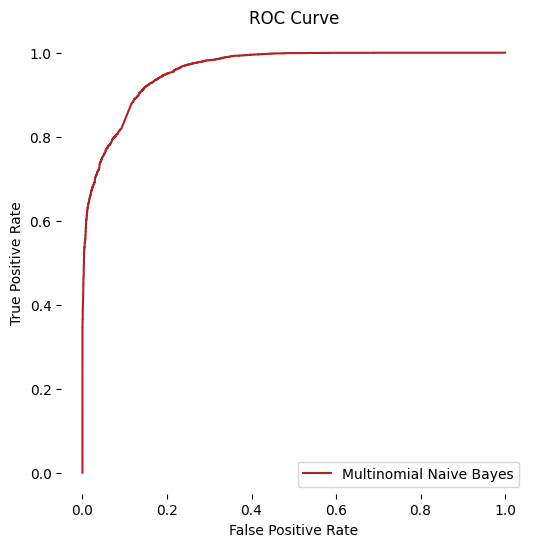

In [50]:
plot_roc_curve(y_test, prob_preds[:, 1], label="Multinomial Naive Bayes")

As we can see, our model isn't well calibrated despite its accuracy on the testing data.
***
## K-Nearest Neighbors

This method works by looking at "nearby" outputs. We get an output based on the feature weights and check what similar outputs were from our training data.

### TF-IDF Vectors

These vectors are similar to the count-based vectors from before, but now words are assigned "weight" depending on their importance. The word "dexterity" doesn't tell us much about what author it could be, but the word "Emma" or "ship" could! We also need to consider the words occurrence frequency though, if a word appears a lot, it's less useful. Thus, we get **Term-Frequency Inverse-Document Frequency**!

$$\mathrm{tf}(\mathrm{term}, \mathrm{document}) = 1 + \log(\mathrm{count}(\mathrm{term}, \mathrm{document})) \ \mathrm{if} \ \mathrm{count}(\mathrm{term}, \mathrm{document}) > 0 \ \mathrm{else} 0$$

$$idf(\mathrm{term}) = \log \left( \frac{N}{\mathrm{total \ count}(i)} \right)$$

$$tfidf(\mathrm{term}, \mathrm{document}) = \mathrm{tf}(\mathrm{term}, \mathrm{document}) \times idf(\mathrm{term})$$

Let's make K-Nearest Neighbors using TF-IDF!

In [51]:
# Make the pipeline!
k_pipe = make_pipeline(TfidfVectorizer(max_features=2500, max_df=0.7, stop_words="english", ngram_range=(1, 3)),
                       KNeighborsClassifier(n_neighbors=10))

k_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.7, max_features=2500,
                                 ngram_range=(1, 3), stop_words='english')),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=10))])

In [52]:
predictions = k_pipe.predict(X_test)

Accuracy: 0.5605
Precision: 0.6480
Recall: 0.5688
F1 Score: 0.4973


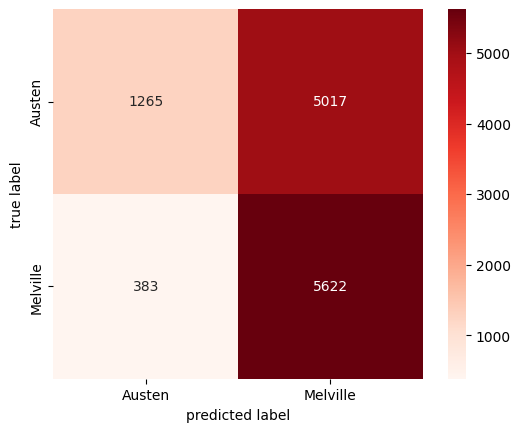

In [53]:
acc, prec, rec, f1, conf = get_metrics(targets=y_test, predictions=predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf, labels=["Austen", "Melville"])

In [54]:
prob_preds = k_pipe.predict_proba(X_test)

print(prob_preds[0])

[0.2 0.8]


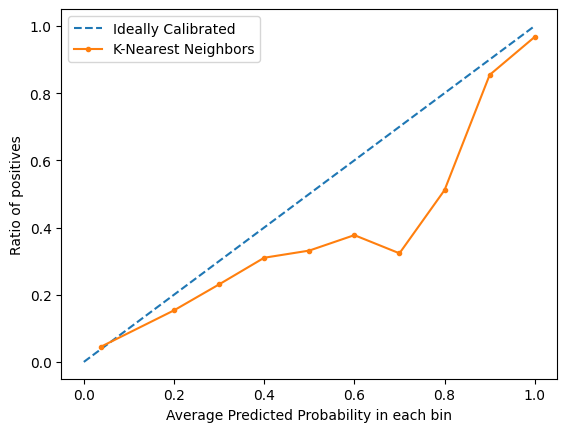

In [55]:
plot_calibration_curve(y_test, prob_preds[:, 1], label="K-Nearest Neighbors")

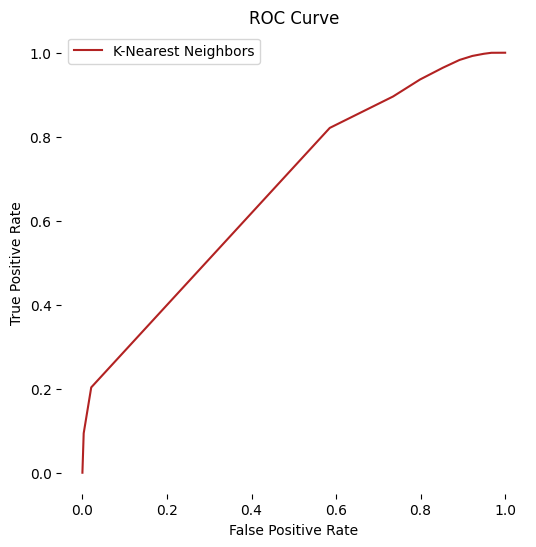

In [56]:
plot_roc_curve(y_test, prob_preds[:, 1], label="K-Nearest Neighbors")

While our label-based metrics went down, the overall calibration is better!
***
## Support Vector Machines

My favorite machine-learning model because the name sounds cool! Also abbreviated as SVMs, these bad boys take the output space of our training data and finds a line such that it is the maximumally separates our classes; this divides the output space into two, the two regions we will use to clasify our results!

In [57]:
# Make the pipeline!
svm_pipe = make_pipeline(TfidfVectorizer(max_features=2500, max_df=0.7, stop_words="english", ngram_range=(1, 3)),
                         LinearSVC(C=1E2))

svm_pipe.fit(X_train, y_train)

/home/computer_cat/miniconda3/envs/pyling/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/computer_cat/miniconda3/envs/pyling/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.7, max_features=2500,
                                 ngram_range=(1, 3), stop_words='english')),
                ('linearsvc', LinearSVC(C=100.0))])

In [58]:
predictions = svm_pipe.predict(X_test)

Accuracy: 0.8744
Precision: 0.8744
Recall: 0.8746
F1 Score: 0.8744


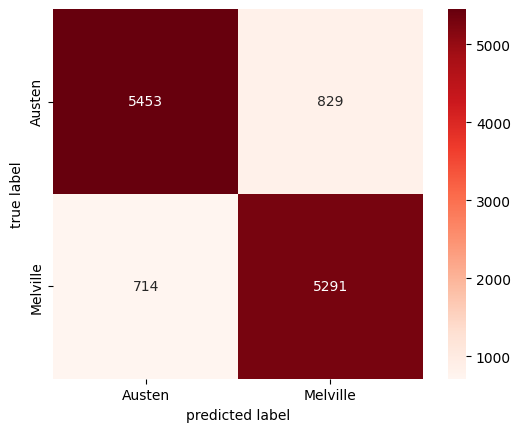

In [59]:
acc, prec, rec, f1, conf = get_metrics(targets=y_test, predictions=predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf, labels=["Austen", "Melville"])

In [60]:
# Might be some slight discrepancy due to sklearn's implementation
prob_preds = svm_pipe.decision_function(X_test)

print(prob_preds[0])

1.325347878588985


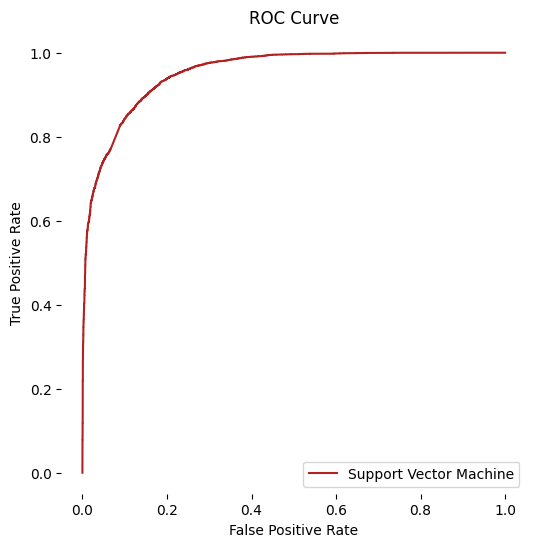

In [61]:
plot_roc_curve(y_test, prob_preds, label="Support Vector Machine")

So far, this is our best model for both calibration and accuracy!
***
## Logistic Regression

This is a very interesting classification technique. It is essentially a linear regression model with a final "layer" that transforms our real number output to be bounded within [0, 1]. This function is called the inverse log-odds (logit) function.

### Linear Regression

$$\eta = \beta_{0} + \beta_{1} x_{1} + \dots + \beta_{n} x_{n}$$

### Logit Function

$$\mathrm{logit}(\eta) = \ln \left( \frac{\eta}{1 - \eta} \right)$$

### Inverse Logit (Softmax)

$$\mathrm{softmax} = \mu = \frac{\exp(\eta)}{1 + \exp(\eta)}$$

![sigmoid](sigmoid.png)

[Link](https://math.stackexchange.com/questions/3816925/how-to-adjust-logit-functions-input-domain)

In [62]:
# Make the pipeline!
log_pipe = make_pipeline(TfidfVectorizer(max_features=2500, max_df=0.7, stop_words="english", ngram_range=(1, 3)),
                         LogisticRegression(penalty="elasticnet", l1_ratio=0.5, solver="saga"))

log_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.7, max_features=2500,
                                 ngram_range=(1, 3), stop_words='english')),
                ('logisticregression',
                 LogisticRegression(l1_ratio=0.5, penalty='elasticnet',
                                    solver='saga'))])

In [63]:
predictions = log_pipe.predict(X_test)

Accuracy: 0.8856
Precision: 0.8860
Recall: 0.8860
F1 Score: 0.8856


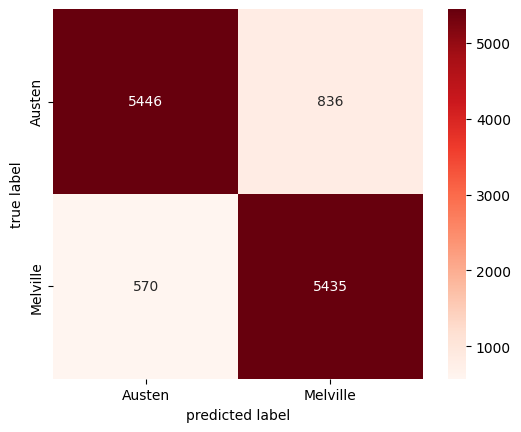

In [64]:
acc, prec, rec, f1, conf = get_metrics(targets=y_test, predictions=predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf, labels=["Austen", "Melville"])

In [65]:
prob_preds = log_pipe.predict_proba(X_test)

print(prob_preds[0])

[0.14025684 0.85974316]


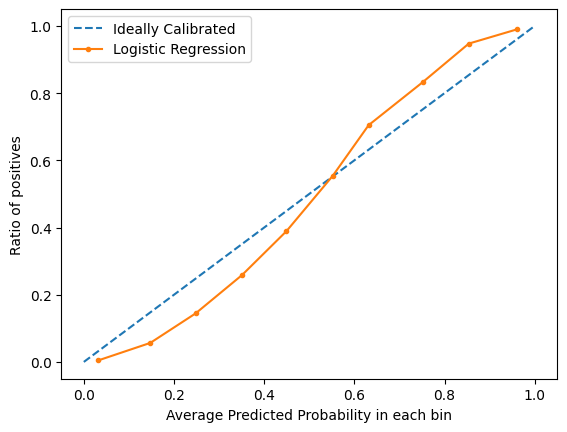

In [66]:
plot_calibration_curve(y_test, prob_preds[:, 1], label="Logistic Regression")

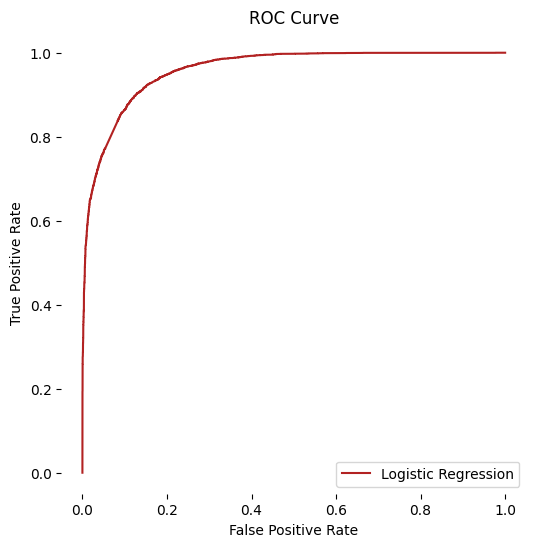

In [67]:
plot_roc_curve(y_test, prob_preds[:, 1], label="Logistic Regression")

Another good model option!
***
## Feed-Forward Neural Network

Now we're in the deep end! The deep-learning end... But anyways, these are some of the simplest deep learning models. There's a lot to talk about, so I'll leave it to the slides. Let's focus on implementing one via `torch`!

### `torch.Tensor`

These are essentially just fancy `numpy` arrays!

In [68]:
# Set the device (GPU training!)
device = "cpu" # if torch.cuda.is_available() else "cuda" 
print(f"Running models on {device}")

Running models on cpu


In [69]:
# Convert to tensors; there are fancier word embedding implementations (word vectors), but let's focus on what we know
# I hate this https://discuss.pytorch.org/t/creating-a-sparse-tensor-from-csr-matrix/13658/4
features = TfidfVectorizer(max_features=2500, max_df=0.7, stop_words="english", ngram_range=(1, 3))

# Outputs a sparse matrics
X_train_sp = features.fit_transform(X_train)
X_test_sp = features.transform(X_test)

In [70]:
# I named them *_t to distinguish them; .to(device) pushes them to the GPU/CPU
# We need to convert the X train and test sparse matrices into a dense one
X_train_t = torch.from_numpy(X_train_sp.toarray().astype(np.float32)).to(device)
X_test_t = torch.from_numpy(X_test_sp.toarray().astype(np.float32)).to(device)
y_train_t = torch.from_numpy(np.array(y_train).astype(np.float32)).to(device)
y_test_t = torch.from_numpy(np.array(y_test).astype(np.float32)).to(device)

In [71]:
# Sparse vector... not a lot of actual "content"
print(X_train_t.max(dim=1))
print(y_train_t)
print(X_train_t.shape, y_train_t.shape)

torch.return_types.max(
values=tensor([0.3619, 0.5895, 0.6001,  ..., 1.0000, 0.4944, 0.3936]),
indices=tensor([ 435,  541,  236,  ..., 1030,  161,  533]))
tensor([1., 0., 1.,  ..., 1., 0., 0.])
torch.Size([28667, 2500]) torch.Size([28667])


### `nn.Sequential`

This is the easiest way to make a simple deep learning model consistent of nothing but a bunch of layers without any tinkering in the middle. Let's break down what this means:

1. We have a vector of 2500 features, `nn.Linear(2500, 5000)` takes these and outputs a vector of 5000 features.
2. We then feed that through the **ReLU** activation function.
3. We lastly take the 5000 features and output a single number with `nn.Linear(5000, 1)`.

**NOTE:** `nn.Dropout(p=0.2)` means, during training, we do not backpropagate through 20% of the weights randomly each step. This helps prevent overfitting. 

In [72]:
model = nn.Sequential(OrderedDict([('lin1', nn.Linear(2500, 5000)),
                                   ("dropout", nn.Dropout(p=0.2)),
                                   ('relu1', nn.ReLU()),
                                   ('lin2', nn.Linear(5000, 1)),
                                   ('sigmoid', nn.Sigmoid())]))
model = model.to(device)

print(model)

Sequential(
  (lin1): Linear(in_features=2500, out_features=5000, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu1): ReLU()
  (lin2): Linear(in_features=5000, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### Loss & The Optimizer

We need a way to measure how off our model is from the actual output, the **loss** function. For a binary classification task, this will be the **Binary Cross-Entropy Loss**, which is analogous to the **Bernoulli Distribution** we usually use for Logistic Regression. The next step is to figure out how to perform **Gradient Descent** each step of an epoch, this is the optimizer's job; to adjust the weights each step based on the loss based on the values gotten during back propagation. Lastly, we use a **learning rate scheduler** to change the learning rate throughout training. This is similar to a concept known as **simulated annealing**, where we start out with large step changes and slowly decrease the amount we step as time goes on. This allows us to explore multiple peaks before settling on one.

In [73]:
learning_rate = 1E-1  # 0.1
criterion = nn.BCELoss() # Bin. Cross Entropy
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.05, total_iters=20_000)

### Training

We train in **batches**, we run through all the training examples in small subsets. Running through all of these subsets is considered one **epoch**. This helps prevent overfitting and reduces the amount of memory needed for one epoch.

#### The Dataset

We can make batching easier by implementing a simple dataset class based on `torch.utils.data`.

In [74]:
class AuthorDataset(Dataset):

    def __init__(self, transform=None):

        self.x = X_train_t
        self.y = y_train_t.reshape((y_train_t.shape[0], 1))
        self.n = X_train_t.shape[0]

        # Modify the data if necessary (for the RNN)
        self.trans = transform

    def __getitem__(self, index):
        if self.trans:
            return self.trans((self.x[index], self.y[index]))
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n

dataset = AuthorDataset()
dataloader = DataLoader(dataset, batch_size=32)

print(dataloader.__iter__().__next__()[0][0])
print(dataloader.__iter__().__next__()[1][0])

tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([1.])


### The Training Loop

In [79]:
epochs = 3
loss = train_dl(model=model, epochs=epochs, dataloader=dataloader,
                criterion=criterion, optimizer=optimizer)

epoch: 1/3, step: 0/896, loss: 0.31970
epoch: 1/3, step: 100/896, loss: 0.27569
epoch: 1/3, step: 200/896, loss: 0.26202
epoch: 1/3, step: 300/896, loss: 0.20525
epoch: 1/3, step: 400/896, loss: 0.34180
epoch: 1/3, step: 500/896, loss: 0.21943
epoch: 1/3, step: 600/896, loss: 0.18815
epoch: 1/3, step: 700/896, loss: 0.18671
epoch: 1/3, step: 800/896, loss: 0.37277
epoch: 2/3, step: 0/896, loss: 0.27508
epoch: 2/3, step: 100/896, loss: 0.22533
epoch: 2/3, step: 200/896, loss: 0.25677
epoch: 2/3, step: 300/896, loss: 0.16027
epoch: 2/3, step: 400/896, loss: 0.29614
epoch: 2/3, step: 500/896, loss: 0.19168
epoch: 2/3, step: 600/896, loss: 0.15513
epoch: 2/3, step: 700/896, loss: 0.14859
epoch: 2/3, step: 800/896, loss: 0.32649
epoch: 3/3, step: 0/896, loss: 0.23780
epoch: 3/3, step: 100/896, loss: 0.19359
epoch: 3/3, step: 200/896, loss: 0.23029
epoch: 3/3, step: 300/896, loss: 0.13385
epoch: 3/3, step: 400/896, loss: 0.28664
epoch: 3/3, step: 500/896, loss: 0.18115
epoch: 3/3, step: 600/

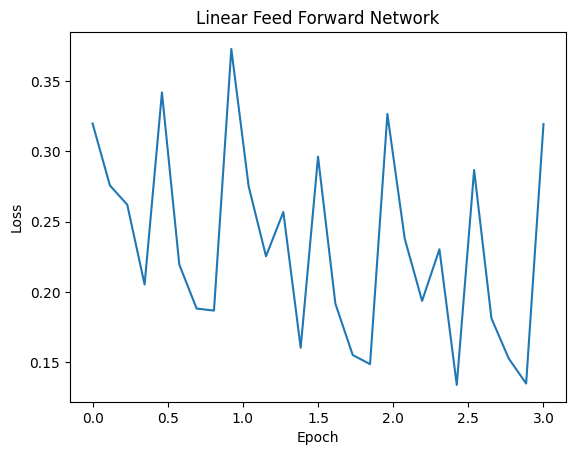

In [81]:
plot_loss(loss, epochs, model_name="Linear Feed Forward Network")

Now let's check its metrics via model **inferencing**, aka asking it a question.

In [82]:
model.train(False)  # Don't track gradients (inferencing)
probabilities = model(X_test_t)
print(probabilities)
print(probabilities.round())

tensor([[0.9296],
        [0.8004],
        [0.0519],
        ...,
        [0.9635],
        [0.9989],
        [0.7768]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]], grad_fn=<RoundBackward0>)


In [83]:
# Flatten and convert to numpy array
# Detach it from a specific device, squeeze it and convert
probabilities = probabilities.detach().squeeze(dim=1).numpy()
predictions = probabilities.round()
print(probabilities)
print(predictions)

[0.9295942  0.8004129  0.05194068 ... 0.9635142  0.9989268  0.7767916 ]
[1. 1. 0. ... 1. 1. 1.]


Accuracy: 0.8857
Precision: 0.8856
Recall: 0.8856
F1 Score: 0.8856


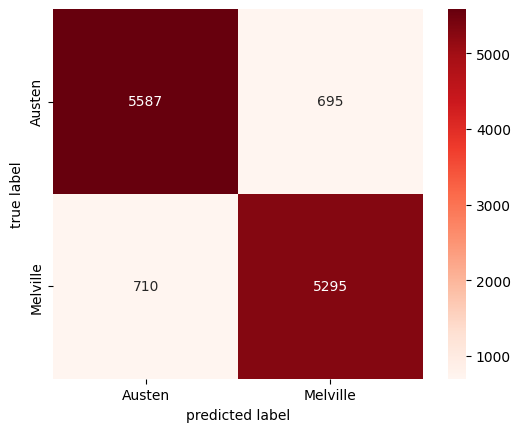

In [84]:
acc, prec, rec, f1, conf = get_metrics(targets=y_test, predictions=predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf, labels=["Austen", "Melville"])

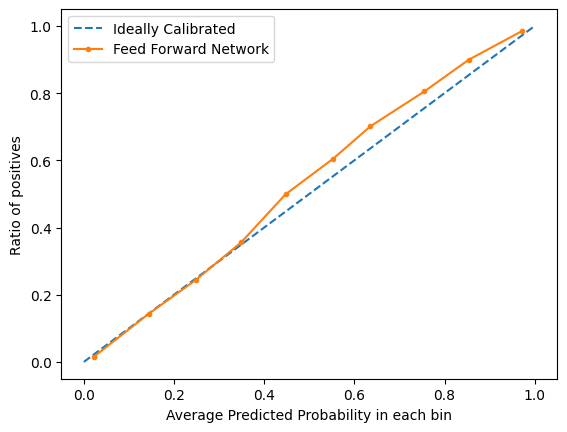

In [85]:
plot_calibration_curve(y_test, probabilities, label="Feed Forward Network")

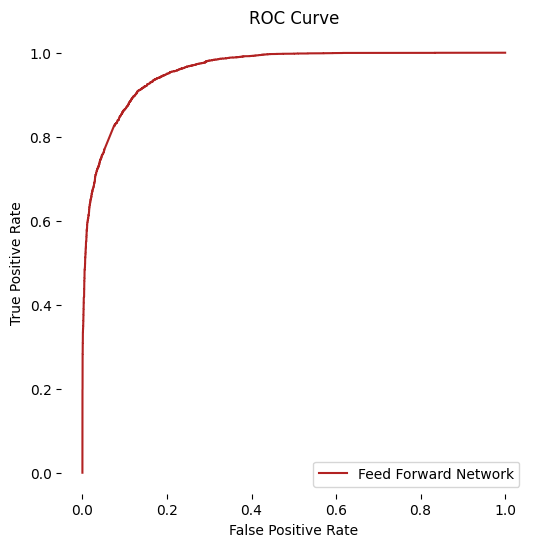

In [87]:
plot_roc_curve(y_test, probabilities, label="Feed Forward Network")

This was our best model yet! But what were some issues/annoyances you saw? Was the increase in performance and calibration from the [logistic regression](#logistic-regression) model worth it?
***
## Recurrent Neural Network

Oh boy! This one's a doozy. This is another deep learning technique that is typically applied in **time-series analysis**, something most NLP tasks can be considered. Essentially, a **time series** is a collection of datapoints given order; a **sequence**. Time series deep learning models allow us to consider the order of data and output answers based on the previous inputs. The most basic of these models is the **Recurrent Neural Network (RNN)** and its modifications the **Long-Short Term Memory (LSTM)** Network and the **Gated Recurrent Unit(GRU)**.

### The Model

Unlike a simple FFNN, we need to make some changes to the output of our model to adapt it for classification. RNNs output an answer (a vector) at each time step, but we only care about the last output for classification! This means `nn.Sequential` isn't enough, and we need to make an actual `nn.Module` class.

In [88]:
# Create the Neural Network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, device):
        super().__init__()

        self.layers = num_layers
        self.hidden_size = hidden_size
        self.device = device

        # batch_size=True means that the input x needs to be a tuple := (batch_size, sequence, input_size)
        # Also GRU (Same everything) and LSTM (Forward needs cell state defined like h0, passed as tuple with h0)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
       
    def forward(self, x):

        h0 = torch.zeros(self.layers, x.shape[0], self.hidden_size).to(self.device)

        # out = (batch_size, seq_length, hidden_size)
        out, _ = self.rnn(x, h0) # Outputs all the hidden states and the hidden state at step N
        # We want only the last state's vector for all in the batches 
        out = out[:, -1, :]

        out = self.linear(self.relu(out))
        
        return self.sigmoid(out)

We also need to transform our TF-IDF vectors into a time-series format ($B \times T \times F$). Essentially, the RNN is going to have $T$ time steps where each time step is a vector of $F$ features; this is then ran on $B$ examples of this format. And thus, $T \times F = 2500$, the original number of features!

In [89]:
class ToTimeSeries():
    def __init__(self, reshape: tuple[int, int]):
        self.reshape = reshape

    def __call__(self, sample):
        inputs, targets = sample
        return inputs.reshape(self.reshape), targets
    
    def batch_shape(self, inputs):
        return inputs.reshape((inputs.shape[0], *self.reshape))
    
transform = ToTimeSeries((5, 500))

In [90]:
model = RNN(500, 500, 3, device).to(device)
dataloader = DataLoader(AuthorDataset(transform=transform), batch_size=32)
dataloader.__iter__().__next__()[0].shape

torch.Size([32, 5, 500])

In [91]:
learning_rate = 1E-3  # 0.001
criterion = nn.BCELoss() # Bin. Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # New optimization schema!
# lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.05, total_iters=1000)

Let's train!

In [92]:
epochs = 3
loss = train_dl(model, epochs, dataloader, criterion, optimizer)

epoch: 1/3, step: 0/896, loss: 0.69686
epoch: 1/3, step: 100/896, loss: 0.45367
epoch: 1/3, step: 200/896, loss: 0.46891


epoch: 1/3, step: 300/896, loss: 0.17551
epoch: 1/3, step: 400/896, loss: 0.57054
epoch: 1/3, step: 500/896, loss: 0.36993
epoch: 1/3, step: 600/896, loss: 0.28485
epoch: 1/3, step: 700/896, loss: 0.26087
epoch: 1/3, step: 800/896, loss: 0.47224
epoch: 2/3, step: 0/896, loss: 0.29992
epoch: 2/3, step: 100/896, loss: 0.29822
epoch: 2/3, step: 200/896, loss: 0.42455
epoch: 2/3, step: 300/896, loss: 0.07122
epoch: 2/3, step: 400/896, loss: 0.25175
epoch: 2/3, step: 500/896, loss: 0.10208
epoch: 2/3, step: 600/896, loss: 0.26386
epoch: 2/3, step: 700/896, loss: 0.09932
epoch: 2/3, step: 800/896, loss: 0.33196
epoch: 3/3, step: 0/896, loss: 0.34699
epoch: 3/3, step: 100/896, loss: 0.18541
epoch: 3/3, step: 200/896, loss: 0.32913
epoch: 3/3, step: 300/896, loss: 0.10649
epoch: 3/3, step: 400/896, loss: 0.19610
epoch: 3/3, step: 500/896, loss: 0.18151
epoch: 3/3, step: 600/896, loss: 0.32616
epoch: 3/3, step: 700/896, loss: 0.11369
epoch: 3/3, step: 800/896, loss: 0.30544
Final loss: 0.280424

The metrics as always.

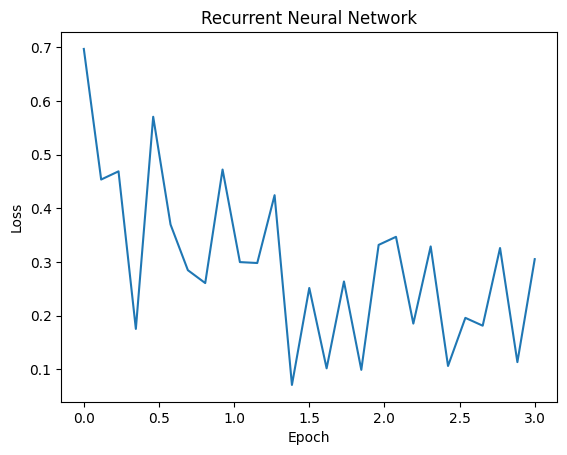

In [93]:
plot_loss(loss, epochs, model_name="Recurrent Neural Network")

Now let's check its metrics

In [94]:
model.train(False)
probabilities = model(transform.batch_shape(X_test_t))
print(probabilities)
print(probabilities.round())

tensor([[0.9831],
        [0.9262],
        [0.2409],
        ...,
        [0.8380],
        [0.9731],
        [0.9141]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]], grad_fn=<RoundBackward0>)


In [95]:
# Flatten and convert to numpy array
# Detach it from a specific device, squeeze it and convert
probabilities = probabilities.detach().squeeze(dim=1).numpy()
predictions = probabilities.round()
print(probabilities)
print(predictions)

[0.98313034 0.9262347  0.24094594 ... 0.83797926 0.9731425  0.914147  ]
[1. 1. 0. ... 1. 1. 1.]


Accuracy: 0.8519
Precision: 0.8525
Recall: 0.8524
F1 Score: 0.8519


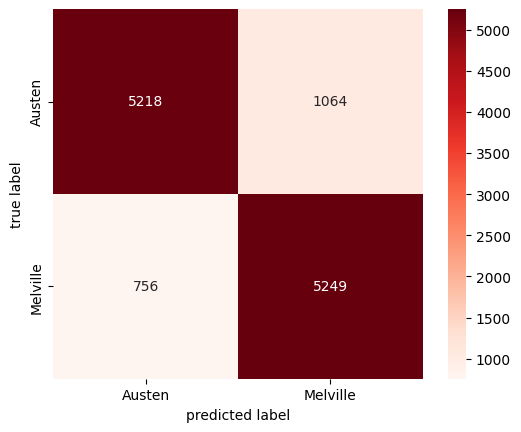

In [96]:
acc, prec, rec, f1, conf = get_metrics(targets=y_test, predictions=predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf, labels=["Austen", "Melville"])

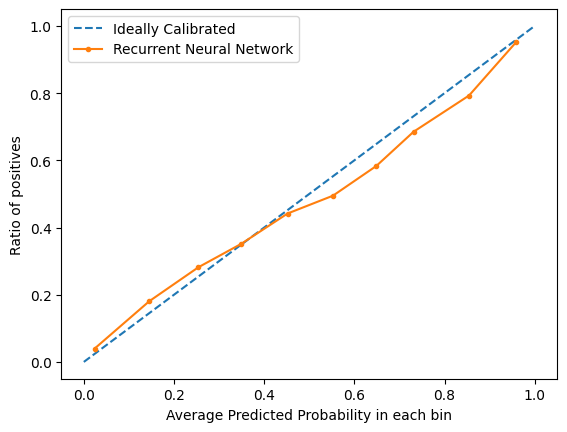

In [97]:
plot_calibration_curve(y_test, probabilities, label="Recurrent Neural Network")

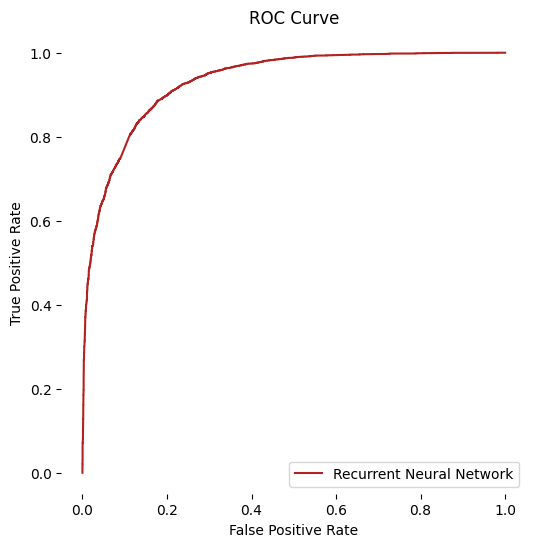

In [98]:
plot_roc_curve(y_test, probabilities, label="Recurrent Neural Network")

We can add more hidden layers, increase the hidden unit size and experiment with the time-series formation to find the most optimal configuration!
***
## Simple Transformer (DOES NOT WORK)

We continue our peruse of deep learning techniques with the **transformer**, a recent invention proposed in the (now (in)famous) paper, [*Attention Is All You Need*](https://arxiv.org/abs/1706.03762). While an extremely simplified explanation of it is, "it's just a bunch of RNNs stacked on top of each other," we can go a little more in-depth. It differs from our normal RNNs in several major ways:

1. The input of a transformer is **bi-directional**, meaning we consider all inputs at once rather than in sequence (like an RNN). This means that the input is **unordered**; we therefore add an additional **positional encoding** step before feeding it to the actual model. The goal here is to encode some information about feature position.

2. This is an **encoder-decoder** model architecture. Essentially, there are two smaller models which make up this larger one. [Here](https://medium.com/analytics-vidhya/encoders-decoders-sequence-to-sequence-architecture-5644efbb3392)'s a good explanation on them using RNNs.

3. Transformers have an **attention** mechanism that, in the simplest idea, let's them """focus""" (cannot add enough quotation marks) on important local features per word. For example, "The robot lost their book in the powerful magnet factory." When evaluating the word "robot," the transformer will """focus""" on it and its associated words ("their," "book," etc.) the most. This is a complicated topic and I suggest you check out this [article](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/). Yes, they were okay, someone got it for them.

4. To follow that, in a transformer model, the encoder is bidirectional, but the decoder is still **autoregressive**, meaning it functions similarly to an RNN, taking input one at a time. This also means that, while input needs to be a certain length (and usually **padded**), our output can be of any length!

5. One last confusing thing. Modern **LLMs (Large Language Models)** are now usually "only the decoder" (GPT models popularized this). These are called **autoregressive models**, just like our familiar RNNs. Yet, transformers can refer to both of these model architectures, so it's important to know the model itself.

If you want to learn more, check out those links and this awesome series of tutorials:

- [Explanation](http://jalammar.github.io/illustrated-transformer/)
- [Paper and Code](http://nlp.seas.harvard.edu/2018/04/03/attention.html)

Now, let's make an extremely small and simple transformer model in `torch`. I followed this [tutorial](https://towardsdatascience.com/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1) originally, and then [this one](https://n8henrie.com/2021/08/writing-a-transformer-classifier-in-pytorch/) to make the classification transformer (which is only the encoder). The [`torch` documention](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder) is also a great source of help!

In [99]:
class PositionalEncoding(nn.Module):
    """
    Pads our vectors to the transformer's input length and
    encodes positional information before its forward pass.
    Mostly copied from that tutorial.
    """
    def __init__(self, d_model, dropout_p, max_len):
        super().__init__()

        # Info
        self.dropout = nn.Dropout(dropout_p)

        # Positional encoding using the tutorial formula
        pos_encoding = torch.zeros(max_len, d_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1)  # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)) / d_model)  # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)

    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
            # Residual connection + pos encoding
            return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])


In [100]:
# Create the Neural Network
class Transformer(nn.Module):
    def __init__(self, input_size, 
                 d_model, num_heads,
                 feed_forward, num_enc_layers, 
                 dropout_p):
        super().__init__()

        # Information
        self.model_type = "Transformer"
        self.dim = d_model

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model=d_model,
                                                      dropout_p=dropout_p,
                                                      max_len=input_size)
        
        # Token embedding to be passed to the transformer
        self.embedding = nn.Embedding(input_size, d_model)

        # Actual model
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,
                                                        nhead=num_heads,
                                                        dim_feedforward=feed_forward,
                                                        dropout=dropout_p,
                                                        batch_first=True)

        self.transformer = nn.TransformerEncoder(encoder_layer=self.encoder_layer,
                                                 num_layers=num_enc_layers)

        # Classification head
        self.linear1 = nn.Linear(d_model, 100)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(100, 1)

        # Probabilities
        self.sigmoid = nn.Sigmoid()

    # NOTICE THE DIFFERENT FORWARD FUNCTION
    def forward(self, x):
        """
        src: (batch size, source sequence length)
        tgt: (batch size, target sequence length)
        """

        # Embedding + positional encoding
        input = self.embedding(x) * math.sqrt(self.dim)  # From paper
        input = self.positional_encoding(input)

        # Now to actually run the damn model
        out = self.transformer(input)
        out = out.mean(dim=1)

        # Classification head
        out = self.linear1(out)
        out = self.relu(out)
        out = self.linear2(out)

        return self.sigmoid(out)


As if this wasn't complicated enough, we need to reformate the input directly from the text. Meaning we need to make a **tokenizer** which takes a word and outputs its associated vector, this time, we'll learn it during training!

In [101]:
class Tokenizer:

    # SOS and EOS token indices
    SOS = 0
    EOS = 1
    UNK = 2

    def __init__(self) -> None:

        self.word2ind = {}
        self.word2count = {}
        self.ind2word = {0: "SOS", 1: "EOS", 2: "UNK"}  # Special tokens
        self.n_words = 2 # Start with SOS and EOS

    def __call__(self, inputs, target = False, padding=1000, device="cpu"):

        if not target:
            for sent in inputs:
                self.addSent(sent)

        ids = np.zeros((len(inputs), padding + 2), dtype=np.int32)

        for idx, sent in enumerate(inputs):
            
            tokens = nltk.word_tokenize(sent)
            input_ids = self.indexesFromSentence(tokens[:padding])
            input_ids.append(Tokenizer.EOS)
            input_ids = [Tokenizer.SOS] + input_ids
            ids[idx, :len(input_ids)] = input_ids

        return torch.LongTensor(ids).to(device)

    def __len__(self):
        return self.n_words
    
    def addSent(self, sent: str) -> None:
        for token in nltk.word_tokenize(sent):
            self.addWord(token)

    def addWord(self, word: str) -> None:

        if word not in self.word2ind:

            self.word2ind[word] = self.n_words
            self.word2count[word] = 1
            self.ind2word[self.n_words] = word
            self.n_words += 1

        else:
            self.word2count[word] += 1

    # Dataloading
    def indexesFromSentence(self, sentence: list[str]) -> list[int]:
        return [self.word2ind[word] if word in self.word2ind else self.UNK for word in sentence]

In [102]:
tokenizer = Tokenizer()
input_ids = tokenizer(X_train, device=device)

print(f"There are {len(tokenizer)} words")

There are 33316 words


In [103]:
# Sanity check, I know I've lost mine!!!
print(input_ids[200:202, :])
print(input_ids.shape)
print(len(X_train))
print(y_train_t.shape)

tensor([[   0,  413, 1752,  ...,    0,    0,    0],
        [   0,   27,    7,  ...,    0,    0,    0]])
torch.Size([28667, 1002])
28667
torch.Size([28667])


In [104]:
dataset = TensorDataset(input_ids,
                        y_train_t.reshape(y_train_t.shape[0], 1))
dataloader = DataLoader(dataset=dataset, batch_size=32)
print(dataloader.__iter__().__next__()[0])
print(dataloader.__iter__().__next__()[1])

tensor([[  0,   2,   3,  ...,   0,   0,   0],
        [  0,  50,  25,  ...,   0,   0,   0],
        [  0,  63,   7,  ...,   0,   0,   0],
        ...,
        [  0, 145,  62,  ...,   0,   0,   0],
        [  0, 193,  53,  ...,   0,   0,   0],
        [  0, 171,  46,  ...,   0,   0,   0]])
tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]])


And finally, we can begin training. Our input size is the number of words in our vocabulary since that is what our embedding tracks (the first part of the model).

In [105]:
model = Transformer(input_size=len(tokenizer), d_model=8, num_heads=4,
                    feed_forward=40, num_enc_layers=3, dropout_p=0.01) \
                    .to(device)

In [106]:
learning_rate = 1E-4  # 0.0001
criterion = nn.BCELoss() # Bin. Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

We need a special training loop because we have to modify the input before passing it off to our model. This was also modified from the tutorial, can you tell I did this part at the last second? Finally, notice how we train for *only one epoch!* It is common (espeically for LLMs) to train on a small amount of epochs due to their size and the amount of data they are given. In fact, we are only training until we reach a certain loss because when I previous ran this, it went really bad...

| Loss  | Confusion Matrix |
|---|---|
| ![Previous run's loss, overfitted](loss.png) | ![Confusion matrix shows that it overfitted because it's all in one column](confusion_matrix.png) |

In [107]:
"""
Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
"""

# This makes sure we update gradients    
model.train()

steps = len(dataloader)
loss = 0
loss_tracker = []

for i, (inputs, labels) in enumerate(dataloader):

    # Standard training except we pass in y_input and tgt_mask
    y_pred = model(inputs)
    loss = criterion(y_pred, y_pred)

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    loss = loss.item()

    # Show statistics and track loss change over time
    if i % 100 == 0:
        print(f'step: {i}/{steps}, loss:{loss: .5f}')
        loss_tracker.append(loss)

    # Variable epoch termination
    if loss <= .15:
        break

print(f"Final loss: {loss}")

step: 0/896, loss: 0.66935
step: 100/896, loss: 0.55073
step: 200/896, loss: 0.37876
step: 300/896, loss: 0.22424
Final loss: 0.1498589813709259


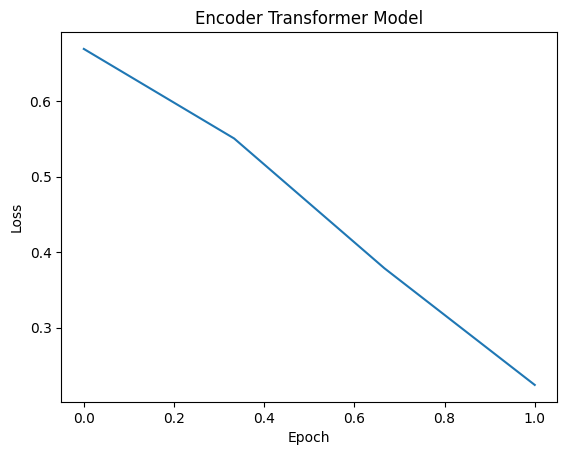

In [117]:
sns.lineplot(x = np.linspace(start=0, stop=1, num=len(loss_tracker) * 1), y=loss_tracker)
plt.title("Encoder Transformer Model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [118]:
# Tokenize our test set
test_inputs = tokenizer(X_test, target=True)  # Don't capture any new words
print(test_inputs.shape)

torch.Size([12287, 1002])


In [119]:
model.train(False)
probabilities = model(test_inputs[:3000])  # Only the first 3k because of RAM
print(probabilities)
print(probabilities.round())

tensor([[0.0343],
        [0.0348],
        [0.0340],
        ...,
        [0.0341],
        [0.0344],
        [0.0341]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)


In [120]:
# Flatten and convert to numpy array
# Detach it from a specific device, squeeze it and convert
probabilities = probabilities.detach().squeeze(dim=1).numpy()
predictions = probabilities.round()
print(probabilities)
print(predictions)

[0.03429798 0.03475418 0.03395286 ... 0.03410142 0.03437712 0.03409854]
[0. 0. 0. ... 0. 0. 0.]


Accuracy: 0.5147
Precision: 0.2573
Recall: 0.5000
F1 Score: 0.3398


/home/computer_cat/miniconda3/envs/pyling/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


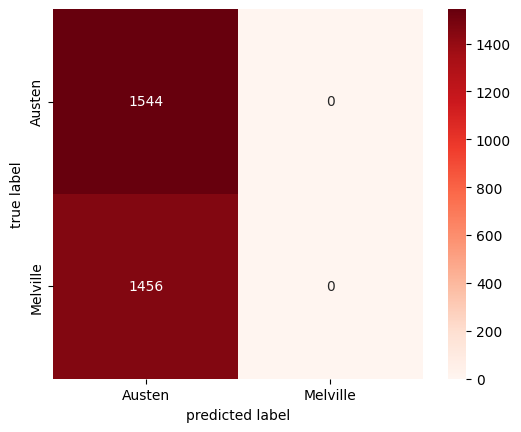

In [121]:
acc, prec, rec, f1, conf = get_metrics(targets=y_test[:3000], predictions=predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf, labels=["Austen", "Melville"])

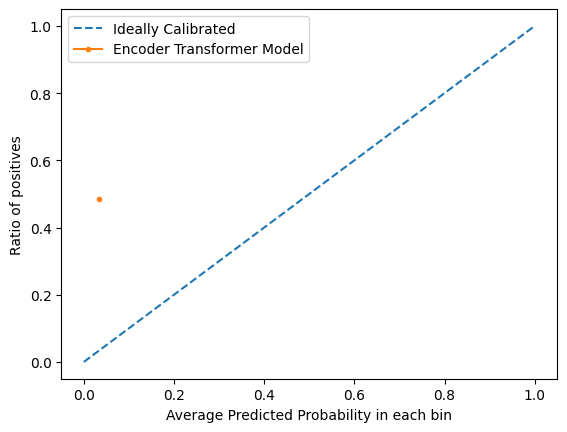

In [122]:
plot_calibration_curve(y_test[:3000], probabilities, label="Encoder Transformer Model")

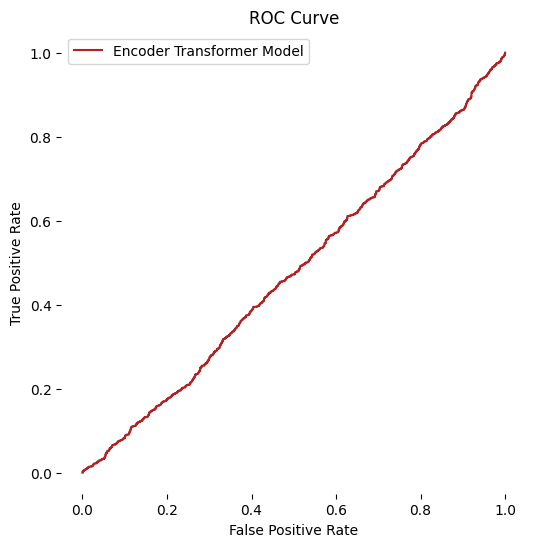

In [123]:
plot_roc_curve(y_test[:3000], probabilities, label="Encoder Transformer Model")

I really tried to get the transformer model to work, but I just don't know what's wrong. It seemed to be doing well in the training stage, but then completely fails at the inference stage. If anyone can help me here to improve the tutorial in the future, it would be greatly appreciated.
***
## HuggingFace Transformers

I am not going to make a custome HuggingFace transformer for this. [HuggingFace](https://huggingface.co) is a famous organization dedicated to open-source deep learning models. They are very famous for their extensive library of datasets, models and robust interface that allows you to easily fine-tune models ranging from NLP to **computer vision (CV)**. The idea is that people upload **pre-trained** models; models that have been trained to perform a basic task either **supervised** (given output labels) or **unsupervised** (no labels given; for example **clustering** data into similar categories based on features). You are then able to take these models and use them as is or **finetune** them. Finetuning is when you take a pre-trained model and further train it to perform better at a certain task or dataset. This is an extremely common technique that falls under the umbrella term **transfer learning**: taking a model that can do one task and training it to do a similar task. It's been shown that transfer learning helps the model get a "head-start" learning the new task if they are similar enough.

HuggingFace's `transformers`, `datasets` and `evaluate` libraries allow you to easily train large transformer models without even looking at `torch` (or it's major competitor, `keras`/`tensorflow`). Nevertheless, you can easily combine it with `torch` and/or `tensorflow` to create robust, customizable pipelines! If you want to learn more, check out the link in this chapter's first paragraph. Their tutorial series is extensive and thorough. They also have model documentation to help you better utilize and understand the models you use! To end this exhaustively detailed notebook, let's just do some model inferencing on my favorite task, **machine translation**!

In [124]:
# Creates a pipeline using this model
pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-en-es")

In [125]:
texts = ["Hey, how are you?",
         "Did you enjoy my presentation?",
         "Do you have any questions, comments or concerns?",
         "This notebook available at my GitHub, AlejandroCiuba!",
         "Thanks for listening to me ramble for about an hour (or more...)"]

for text in texts:
    print(pipe(text))

[{'translation_text': 'Hola, ¿cómo estás?'}]
[{'translation_text': '¿Te gustó mi presentación?'}]
[{'translation_text': '¿Tiene alguna pregunta, comentario o preocupación?'}]
[{'translation_text': '¡Este cuaderno está disponible en mi GitHub, Alejandro Ciuba!'}]
[{'translation_text': 'Gracias por escucharme divagar durante una hora (o más...)'}]
